<b>Загружаем необходимые библиотеки </b>

Pandas будем использовать для создания ДатаФреймов<br>
Matplotlib будем использовать для создания графиков<br>
Requests будем использовать для работы с API <br>
Numpy будем использовать для подсчета корреляций <br>
Foilum будем использовать для создания интерактивных карт<br>
Ipywidgets будем использовать для создания удобных переключателей между линиями и датами<br>

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import folium
from ipywidgets import interact, widgets

Будем работать с API портала открытых данных правительства Москвы. Данные имеют ограничение на экспорт, в каждой json - табличке невозможно экспортировать более 1000 строк, поэтому методами &$top=n&$skip=m мы получаем срез из m элементов начиная с n элемента. <br>
Датасет, который нас интересует - https://data.mos.ru/opendata/62743?ysclid=lx7qaqvaco316581460 <br>
В этом датасете дана информация по годам и кварталам для каждой линии каждой станции метро. Кроме того, в датасете дана информация о количестве зашедших и вышедших со станции людей. 

In [52]:
#ссылки на АPI файлы
json_url1 = 'https://apidata.mos.ru/v1/datasets/62743/rows?api_key=372b5cbf-501e-4cd8-9d76-7ada9653e53e&$top=1000&$'
json_url2 = 'https://apidata.mos.ru/v1/datasets/62743/rows?api_key=372b5cbf-501e-4cd8-9d76-7ada9653e53e&$top=1000&$skip=1000'
json_url3 = 'https://apidata.mos.ru/v1/datasets/62743/rows?api_key=372b5cbf-501e-4cd8-9d76-7ada9653e53e&$top=1000&$skip=2000'
json_url4 = 'https://apidata.mos.ru/v1/datasets/62743/rows?api_key=372b5cbf-501e-4cd8-9d76-7ada9653e53e&$top=1000&$skip=3000'

files = [json_url1, json_url2, json_url3, json_url4]
combined_data = []
dfs = []
#для каждой ссылки запрашиваем JSON файл и добавляем ее в массив датафреймов dfs
for url in files:
    # Запрашиваем файл
    response = requests.get(url)
    # Создаем датафрейм из JSON
    df = pd.DataFrame(response.json())
    # Закидываем датафрейм в массив датафреймов с данными
    dfs.append(df)

# Соединяем все датафреймы из массива dfs в один большой датафрейм со всей информацией 
combined_df = pd.concat(dfs, ignore_index=True)

# Проверяем как он выглядит (а выглядит он так себе)
print(combined_df)

       global_id  Number                                              Cells
0     2641199606       1  {'NameOfStation': 'Деловой центр', 'Line': 'Бо...
1     2664615882       2  {'NameOfStation': 'Шелепиха', 'Line': 'Московс...
2     2664615880       3  {'NameOfStation': 'Площадь Гагарина', 'Line': ...
3     2664615867       4  {'NameOfStation': 'Лихоборы', 'Line': 'Московс...
4     2664648952       5  {'NameOfStation': 'Автозаводская', 'Line': 'Мо...
...          ...     ...                                                ...
3706  1139050976     707  {'NameOfStation': 'Деловой центр', 'Line': 'Бо...
3707  1139049567     708  {'NameOfStation': 'Хорошёвская', 'Line': 'Боль...
3708  1138976383     709  {'NameOfStation': 'Петровский парк', 'Line': '...
3709  1138976435     710  {'NameOfStation': 'ЦСКА', 'Line': 'Большая кол...
3710  1139050974     711  {'NameOfStation': 'Шелепиха', 'Line': 'Большая...

[3711 rows x 3 columns]


In [ ]:
#Сохраняем датафрейм в файл. Это пригодится, когда в данных будут пропуски
combined_df.to_csv('resulting_data.csv', index=False, encoding='utf-8')

Можно заметить, что датафрейм получился неудобный. Нам нужно сделать его читабельным. Заметим, что в строках ничего, кроме столбца Cells нам не нужно. Каждая строка в этом столбце представляет из себя словарь с нужной нам информацией

In [56]:
#Функция extract_info построчно проходится по датафрейму, распаковывает словарь и создает строку для нового датафрейма в удобном виде 
def extract_info(row):
    #распаковываем словарь из Cells
    cell_data = row['Cells']
    #создаем строку с нужными названиями столбцов, которые просто берем из словаря, записываем в обновленную строчку новые значения из словаря
    row['NameOfStation'] = cell_data['NameOfStation']
    row['Line'] = cell_data['Line']
    row['Year'] = cell_data['Year']
    row['Quarter'] = cell_data['Quarter']
    row['IncomingPassengers'] = cell_data['IncomingPassengers']
    row['OutgoingPassengers'] = cell_data['OutgoingPassengers']
    return row
# Применяем функцию построчно и сразу собираем в новый датафрейм df
df = combined_df.apply(extract_info, axis=1)

# У нас получатся лишние столбцы, так как мы просто добавляли строчки. Cells мы уже распаковали, другие два столбца не содержат нужную информацию, так что просто отбросим их из нашего датафрейма
df = df.drop(columns=['Cells'])
df = df.drop(columns=['global_id'])
df = df.drop(columns=['Number'])
#Давайте теперь упростим названия линий, это понадобится нам в дальнейшем, когда мы будем загружать другой датасет, с более простыми названиями
for index, row in df.iterrows():
    #пробегаемся по строкам датафрейма и по столбцу Линия ищем названия, которые мы будем менять. Для следующего массива названий необходимо просто срезать пробел и слово линия, так что в этом случае будем просто срезать последние 6 символов
    if row['Line'] in ['Сокольническая линия', 'Замоскворецкая линия', 'Филёвская линия', 'Кольцевая линия', 'Калужско-Рижская линия', 'Таганско-Краснопресненская линия', 'Солнцевская линия', 'Калининская линия', 'Серпуховско-Тимирязевская линия', 'Люблинско-Дмитровская линия', 'Некрасовская линия']:
        df.at[index, 'Line'] = row['Line'][:-6]
    if row['Line'] == 'Арбатско-Покровская линия':
        df.at[index, 'Line'] = "Арбатско-Покровская"
    if row['Line'] == 'Бутовская линия Лёгкого метро':
        df.at[index, 'Line'] = "Бутовская"
    if row['Line'] == 'Московская монорельсовая транспортная система':
        df.at[index, 'Line'] = "Монорельс"
    if row['Line'] == 'Московское центральное кольцо':
        df.at[index, 'Line'] = "МЦК"
    if row['Line'] == 'Филёвская линия':
        df.at[index, 'Line'] = "Филевская"
# Посмотрим, что получилось
print(df)

         NameOfStation                     Line  Year     Quarter  \
0        Деловой центр  Большая кольцевая линия  2024  IV квартал   
1             Шелепиха                      МЦК  2024   I квартал   
2     Площадь Гагарина                      МЦК  2024   I квартал   
3             Лихоборы                      МЦК  2024   I квартал   
4        Автозаводская                      МЦК  2024   I квартал   
...                ...                      ...   ...         ...   
3706     Деловой центр  Большая кольцевая линия  2021   I квартал   
3707       Хорошёвская  Большая кольцевая линия  2021   I квартал   
3708   Петровский парк  Большая кольцевая линия  2021   I квартал   
3709              ЦСКА  Большая кольцевая линия  2021   I квартал   
3710          Шелепиха  Большая кольцевая линия  2021   I квартал   

      IncomingPassengers  OutgoingPassengers  
0                1765925             1782382  
1                 660425              713332  
2                1062004      

Теперь сохраним промежуточный результат в файл, к которому в дальнейшем удобно будет обращаться

In [206]:
df.to_csv('Moscow_metro_data.csv', index=False, encoding='utf-8')

Мы видим, что в дф представлены кварталы и года - не очень удобная форма, давайте объединим эти два столбца в один, назовем его Date.

In [57]:
# словарь будет полезен для маппинга, кроме того, к нему удобно обращаться, если вдруг запутаетесь в датах.
quarter_mapping = {
    'I квартал': '1',
    'II квартал': '2',
    'III квартал': '3',
    'IV квартал': '4'
}

# Для красоты добавим 0 перед номером квартала
quarter_mapping = {key: value.zfill(2) for key, value in quarter_mapping.items()}

# Соберем информацию из колонки Год с информацией из колонки Квартал, замаппенные с нумерацией
df['Date'] = df['Year'].astype(str) + '/' + df['Quarter'].map(quarter_mapping)

# Удалим лишние колонки
df = df[['Date', 'NameOfStation', 'Line', 'IncomingPassengers', 'OutgoingPassengers']]

# Посмотрим, что получилось
print(df)

         Date     NameOfStation                     Line  IncomingPassengers  \
0     2024/04     Деловой центр  Большая кольцевая линия             1765925   
1     2024/01          Шелепиха                      МЦК              660425   
2     2024/01  Площадь Гагарина                      МЦК             1062004   
3     2024/01          Лихоборы                      МЦК             1201510   
4     2024/01     Автозаводская                      МЦК              421776   
...       ...               ...                      ...                 ...   
3706  2021/01     Деловой центр  Большая кольцевая линия             1062070   
3707  2021/01       Хорошёвская  Большая кольцевая линия              687219   
3708  2021/01   Петровский парк  Большая кольцевая линия              752848   
3709  2021/01              ЦСКА  Большая кольцевая линия             2337493   
3710  2021/01          Шелепиха  Большая кольцевая линия              752317   

      OutgoingPassengers  
0           

Первое, что сразу хочется оценить - правдоподобность данных и найти даты, когда в статистике происходит что-то странное. Для этого можно, например, посмотреть на разницу между суммой входящих на станции людей и выходящих со станций людей.

Date
2021/01    -552204
2021/02    -246963
2021/03    -182517
2021/04    4398843
2022/01    -305696
2022/02    -345394
2022/03    -281600
2022/04    -365978
2023/01      -2514
2023/02     -19404
2023/03    -241944
2023/04    -163551
2024/01    -194960
2024/04     -16457
dtype: int64


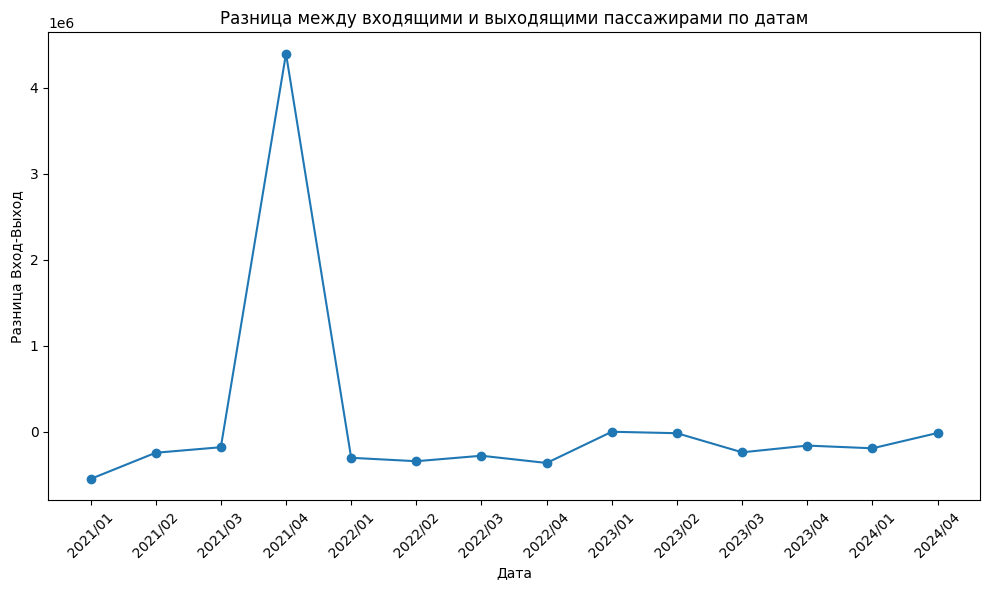

In [60]:
# Найдем сумму входящих с группировкой по дате и сумму выходящих
yearly_quarterly_totals = df.groupby(['Date'])[['IncomingPassengers', 'OutgoingPassengers']].sum()
# Посчитаем разницу между этими числами
yearly_quarterly_totals_difference = yearly_quarterly_totals['IncomingPassengers'] - yearly_quarterly_totals['OutgoingPassengers']
print(yearly_quarterly_totals_difference)
# Нарисуем график этой разницы по датам
plt.figure(figsize=(10, 6))
plt.plot(yearly_quarterly_totals_difference, marker='o', linestyle='-')

plt.xlabel('Дата')
plt.ylabel('Разница Вход-Выход')
plt.title('Разница между входящими и выходящими пассажирами по датам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Обратим внимание на то, что чаще всего разница отрицательная, то есть выходящих людей чуть больше, кроме 2021/04, когда входящих на станцию гораздо больше, чем выходящих. Запомним эту дату. <br>
Вообще, довольно странно, что разница между такими показателями не равна 0. Это можно объяснить через специфику отслеживания входа и выхода. Вход отслеживается однозначно, по приложению карты, которое всегда однозначно можно определить. Выход так не отслеживается, на выходе отслеживаются через датчик движения, часто много людей выходят вместе и датчик срабатывает один раз на несколько человек. Иногда наоборот, датчик срабатывает сверхчувствительно, когда люди не выходят.

Теперь будем импортировать другую карту с API hh.ru, в которой даны названия станций, линии и координаты этих станций. Здесь импорт аналогичен импорту с первой API, но здесь, к счастью, нет необходимости разбивать файл на составляющие - весь файл можно скачать за раз. 

In [61]:
response = requests.get('https://api.hh.ru/metro/1')
df_geo = pd.DataFrame(response.json())

# Сохраним промежуточный вид таблички в файл
df_geo.to_csv('resulting_data_geo.csv', index=False, encoding='utf-8')

#Видим, что формат файла здесь неприятный - столбцы id, name нам не нужны вообще, в столбце line лежит вся нужная информация. Весь файл разделен по линиям, станции этой линии достаются из словаря в строке line по ключу stations,там в виде словаря расположена информация о станции и координатах
def extract_station_info(row):
    # Берем только последнюю строку - словарь
    geo_data = row['lines']
    station_info = geo_data['stations']
    # Создадим списки для информаций из словаря для каждой станции
    stations = []
    lines = []
    latitudes = []
    longitudes = []
    # Пробегаемся по информации о станциях и добавляем для каждой станции информацию в соответствующий список
    for station in station_info:
        stations.append(station['name'])
        # Важно! Мы берем название линии не из информации о станции для каждой линии (ее там), а из словаря, в котором есть название линии, то есть идем обратно на один уровень вверх здесь
        lines.append(geo_data['name'])
        latitudes.append(station['lat'])
        longitudes.append(station['lng'])
    # Собираем из всего этого датафрейм
    df = pd.DataFrame({
        'station': stations,
        'line': lines,
        'lat': latitudes,
        'lng': longitudes
    })
    return df

# Выкидываем 4 последние строчки, так как там лежит информация о МЦД (1,2,3,4), которые не относятся юридически к метро Москвы и не представляют интереса в исследовании
df_geo = df_geo.drop(df_geo.tail(4).index)
#Применяем функцию ко всем строчкам в нашем файле и собираем из этого новый датафрейм с нужной нам информацией
df_geo = pd.concat([extract_station_info(row) for _, row in df_geo.iterrows()], ignore_index=True)
print(df_geo)


               station          line        lat        lng
0           Новокосино   Калининская  55.745113  37.864052
1          Новогиреево   Калининская  55.752237  37.814587
2               Перово   Калининская  55.750980  37.784220
3    Шоссе Энтузиастов   Калининская  55.758090  37.751703
4         Авиамоторная   Калининская  55.751933  37.717444
..                 ...           ...        ...        ...
301       Стахановская  Некрасовская  55.730000  37.760000
302      Нижегородская  Некрасовская  55.730000  37.730000
303          Лефортово  Некрасовская  55.764444  37.702778
304   Электрозаводская  Некрасовская  55.782057  37.705300
305       Авиамоторная  Некрасовская  55.751933  37.717444

[306 rows x 4 columns]


Создаем итоговый файл по станциям с их координатами

In [198]:
df_geo.to_csv('Moscow_metro_data_geo.csv', index=False, encoding='utf-8')

Теперь давайте создадим карту из Folium из геодатафрейма, чтобы визуально посмотреть, хорошо ли себя ведут станции на карте, нет ли выбросов (ошибок) в данных. Обратим внимание на то, что на карте мы увидим все станции, которые когда-либо существовали

In [62]:
# Создаем карту с локацией в Москве
map_center = [55.764414, 37.647859]  
m = folium.Map(location=map_center, zoom_start=10) 

# Для каждой станции проходимся по геодф и используем информацию о ее координатах, чтобы добавить на карту.
for index, row in df_geo.iterrows():
    folium.Marker([row['lat'], row['lng']], popup=row['station']).add_to(m)


# Вывод карты
m

Все отлично, но станция Народное Ополочение во Владимирской области - выглядит скорее как прикол. Явно наблюдаем ошибку в данных, по этому поводу будет совершено обращение техотделу hh для улучшения публичных данных. 

Теперь давайте создадим карту, на которой мы будем видеть кружочек вокруг станции. Красный кружочек будет означать, что станция находится на реконструкции (статистический эквивалент тому - 0 входящих и выходящих пассажиров). Синий кружочек будем тем больше, чем больше входящих на станцию людей зафиксировано в выбранную дату. Дефолтная дата - крайняя, статистической информации в ней очень мало, так что чтобы посмотреть на карту, где количество станций будет существенным нужно выбрать предшествующие периоды

In [64]:
def update_map(date):
    m = folium.Map(location=[55.7525, 38.008889], zoom_start=10)
    
    # Будем пробегаться по геодф, чтобы добавлять кружочки
    for index, row in df_geo.iterrows():
        # В геодф будем брать имя станции и координаты, запиешм в отдельные переменные
        station_name = row['station']
        station_lat = row['lat']
        station_lng = row['lng']
        # Найдем в датафрейме с количеством пассжаиров соответствующие названия станции и даты и получим информацию о количестве пассажиров
        incoming_passengers = df[(df['NameOfStation'] == station_name) & (df['Date'] == date)]['IncomingPassengers'].values
        # Проверка находится ли станция на реконструкции (если станция вообще нашлась)
        if len(incoming_passengers) > 0:
            if incoming_passengers[0] > 0:
                # Радиус будет линейно зависеть от количества пассжаиров, разделим на 200000. Кажется, это наиболее удобный scale, чтобы все было видно
                radius = int(incoming_passengers[0] / 200000) 
                # Создаем маркер на месте станции с заданным радиусом
                folium.CircleMarker(
                    location=[station_lat, station_lng],
                    radius=radius,
                    color='blue',
                    fill=True,
                    fill_opacity=0.5,
                    popup=f'<b>{station_name}</b><br>Входы: {incoming_passengers[0]}'
                ).add_to(m)
            else:
                # Пишем, что станция на реконструкции
                folium.CircleMarker(
                    location=[station_lat, station_lng],
                    radius=5,
                    color='red',
                    fill=True,
                    fill_opacity=0.5,
                    popup=f'<b>{station_name}</b><br> Станция на реконструкции'
                ).add_to(m)
    
    # Выводим карту
    display(m)

# Получаем все даты списком для создания переключателя
dates = df['Date'].unique()

# Создаем переключатель с датами
date_widget = widgets.Dropdown(options=dates, description='Выбрать дату:', disabled=False)

# Подвязываем переключатель на функцию генерации карты
interact(update_map, date=date_widget)

interactive(children=(Dropdown(description='Выбрать дату:', options=('2024/04', '2024/01', '2023/04', '2023/03…

<function __main__.update_map(date)>

Занимательная карта, на ней довольно наглядно видно, что станции, являющиеся пересадочными (расположены рядом на карте и имеющие одинаковый радиус) имеют значительно большее количество входящих пассажиров. Многие нагруженные станции не имеют пересадки на карте, однако являются пересадками на железные дороги, например Славянский бульвар на западе, Выхино на востоке, Царицыно на юге и Тушинская на севере. <br>


In [69]:
# Найдем пересадочные станции, с мыслью, то пересадочные станции чаще всего имеют одинаковые названия
transfer_stations = df_geo['station'].value_counts()
transfer_stations = transfer_stations[transfer_stations > 1].index.tolist()

# Выведем
print("Пересадки:")
print(transfer_stations)

Transfer Stations:
['Кунцевская', 'Электрозаводская', 'Каширская', 'Киевская', 'Деловой центр', 'Нижегородская', 'Авиамоторная', 'Октябрьская', 'Дубровка', 'Печатники', 'Третьяковская', 'Шелепиха', 'Сокольники', 'Савёловская', 'Окружная', 'Тимирязевская', 'Ботанический сад', 'Петровско-Разумовская', 'Владыкино', 'Рижская', 'Проспект Мира', 'Комсомольская', 'Марьина Роща', 'Бульвар Рокоссовского', 'Парк культуры', 'Кутузовская', 'Автозаводская', 'Каховская', 'Таганская', 'Курская', 'Варшавская', 'Текстильщики', 'Арбатская', 'Мичуринский проспект', 'Проспект Вернадского', 'Белорусская', 'Смоленская', 'Шоссе Энтузиастов', 'Парк Победы', 'Лефортово', 'Павелецкая', 'Китай-город']


Теперь давайте найдем самые загруженные станции и самые разгруженные станции для каждой ветки. Зеленым будет наиболее загруженная, красным наименее загруженная. К сожалению, в открытом доступе нет массива данных с полным списком пересадок.  Можно было использовать массив выше для идентификации пересадок, однако иногда пересадочные станции имеют разное название, а иногда одинаковое название имеют станции, не являющиеся пересадкой (Смоленская АПЛ - Смоленская ФЛ), так что вооружившись картой метро посчитаем, сколько из наиболее загруженных/разгруженных пересадки на метро, сколько пересадки на мцд или автобусы, сколько не являются пересадками. Наибольший интерес представляет 2021/01, то есть ситуация до открытия БКЛ.

In [78]:
m = folium.Map(location=[55.7525, 38.008889], zoom_start=10)

def update_map(date, line):
    # Очищаем карту
    m = folium.Map(location=[55.7525, 38.008889], zoom_start=10)
    
    # Фильтруем дф для поиска конкретной линии и конкретной даты
    line_data = df[(df['Line'] == line) & (df['Date'] == date) & (df['IncomingPassengers'] > 0)]
    
    if not line_data.empty:
        # Найдем станцию с максимальным количеством входящих людей
        max_station = line_data.loc[line_data['IncomingPassengers'].idxmax()]

        # Аналогично минимальные
        min_station = line_data.loc[line_data['IncomingPassengers'].idxmin()]

        # Берем информацию о геопозиции
        max_station_geo = df_geo[df_geo['station'] == max_station['NameOfStation']]
        min_station_geo = df_geo[df_geo['station'] == min_station['NameOfStation']]
        
        if not max_station_geo.empty and not min_station_geo.empty:
            max_lat, max_lng = max_station_geo['lat'].iloc[0], max_station_geo['lng'].iloc[0]
            min_lat, min_lng = min_station_geo['lat'].iloc[0], min_station_geo['lng'].iloc[0]

            # Добавляем интересующие маркеры с инфой о нагрузке самых перегруженных
            folium.Marker(
                location=[max_lat, max_lng],
                icon=folium.Icon(color='green'),
                popup=f'<b>{max_station["NameOfStation"]}</b><br>Date: {date}, Incoming Passengers: {max_station["IncomingPassengers"]}'
            ).add_to(m)

            # Аналогичные наименее загруженные
            folium.Marker(
                location=[min_lat, min_lng],
                icon=folium.Icon(color='red'),
                popup=f'<b>{min_station["NameOfStation"]}</b><br>Date: {date}, Incoming Passengers: {min_station["IncomingPassengers"]}'
            ).add_to(m)

            # Выводим карту
            display(m)
        else:
            print("Не найдено")
    else:
        print("Не найдено")

# Получаем названия линий списком
lines = df['Line'].unique()

# Создаем виджеты для выбора линий и дат
date_widget = widgets.Dropdown(options=dates, description='Select Date:', disabled=False)
line_widget = widgets.Dropdown(options=lines, description='Select Line:', disabled=False)

# Выводим виджет
interact(update_map, date=date_widget, line=line_widget)

interactive(children=(Dropdown(description='Select Date:', options=('2024/04', '2024/01', '2023/04', '2023/03'…

<function __main__.update_map(date, line)>

Подсчет дал такие результаты: <br>
По самым загруженным станциям: <br>
Пересадка на метро: 3 линии <br>
Пересадка на автобусы/поезда: 8 <br>
Не пересадка вообще: 3 <br>
По самым НЕзагруженным станциям: <br>
Пересадка на метро: 10 линии <br>
Пересадка на автобусы/поезда: 1 <br>
Не пересадка вообще: 3 <br><br>
Получается, чаще всего незагруженными бывают пересадочные станции, а самыми загруженными станции дальнего сообщения. Стоит заметить, что станции дополнительного сообщения вполне естественным образом становятся самыми загруженными, так как они являются своеобразными воротами в город. Видя эту статистику хочется предположить, что создав на станции пересадку, мы сделаем ее менее вероятно самой загруженной. Само собой, эта гипотеза статистически и логически слабая, однако интуиция за ней действительно стоит - на первый взгляд кажется, что создание пересадки на станции позволяет перекинуть часть нагрузки на станцию на конкретной ветке на другую ветку. Например, людям на Кунцевской теперь не нужно заходить на синюю Кунцевскую и пересаживаться на красную ветку, чтобы добраться до Проспекта Вернадского, теперь можно зайти на Кунцевскую - БКЛ, чтобы доехать до Вернадского. То есть синяя Кунцевская должна таким образом разгружаться. <br>
К данному моменту наша гипотеза выглядит подтвержденной, однако приведенная статистика слаба, нам нужно искать другие пути более точного анализа

Давайте посмотрим на Кольцевую линию. Она является одной из самых загруженных, все станции этой линии являются пересадочными, причем многие из них являются пересадками на вокзалы и автовокзалы. Здесь посчитаем в процентное изменение общего количества входящих по сравнению с первоначальной датой 2021/01

C:\Users\Кирилл\AppData\Local\Temp\ipykernel_27508\462133931.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  koltsevaya_grouped['percentage_change'].fillna(0, inplace=True)


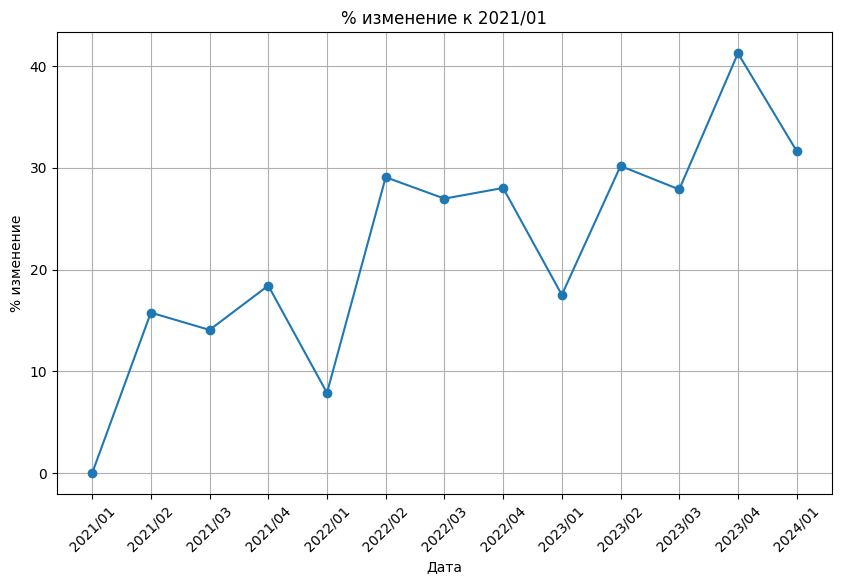

In [80]:
# Фильтрация по линии Кольцеввая
koltsevaya_df = df[df['Line'] == 'Кольцевая']

# Достаем информацию по каждой дате и суммируем входящих пассажиров на все станции
koltsevaya_grouped = koltsevaya_df.groupby('Date')['IncomingPassengers'].sum().reset_index()

# Берем информацию о количестве входящих 2021/01
incoming_passengers_january_2021 = koltsevaya_grouped[koltsevaya_grouped['Date'] == '2021/01']['IncomingPassengers'].values[0]

# Считаем для каждой даты процентное изменение
koltsevaya_grouped['percentage_change'] = ((koltsevaya_grouped['IncomingPassengers'] - incoming_passengers_january_2021) / incoming_passengers_january_2021) * 100

# Заполняем нули 
koltsevaya_grouped['percentage_change'].fillna(0, inplace=True)

# Рисуем график
plt.figure(figsize=(10, 6))
plt.plot(koltsevaya_grouped['Date'], koltsevaya_grouped['percentage_change'], marker='o', linestyle='-')
plt.xlabel('Дата')
plt.ylabel('% изменение')
plt.title('% изменение к 2021/01')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Удивительный результат! Можно заметить, что к данному моменту мы имеем +32%. В целом, за весь период мы видели только положительный прирост, то есть ни в какой квартал количество людей на кольцевой не падало к 2021/01. <br>
Гипотеза начала рушиться?

Посчитаем корреляцию между количеством людей на БКЛ и Кольцевой линии, станет виднее.

In [81]:
# Фильтруем по БКЛ
bolshaya_koltsevaya_df = df[df['Line'] == 'Большая кольцевая линия']

# Фильтруем по Кольцевой
koltsevaya_df = df[df['Line'] == 'Кольцевая']

# Ищем для каждой даты сумму всех входящих людей на БКЛ и КЛ
bolshaya_koltsevaya_grouped = bolshaya_koltsevaya_df.groupby('Date')['IncomingPassengers'].sum()
koltsevaya_grouped = koltsevaya_df.groupby('Date')['IncomingPassengers'].sum()
# Срежем лишнее данные
bolshaya_koltsevaya_grouped = bolshaya_koltsevaya_grouped[:-2]
koltsevaya_grouped = koltsevaya_grouped[:-1]

# Найдем коэффициент корреляции Пирсона
correlation = bolshaya_koltsevaya_grouped.corr(koltsevaya_grouped)

print("Коэффициент корреляции Пирсона:", correlation)

Коэффициент корреляции Пирсона: 0.756942581462011


То есть мы видим, что на БКЛ и на КЛ количество людей в абсолютных значениях растет схожим образом. Именно растет, потому что мы наверняка знаем, что количество людей на БКЛ растет с момента открытия благодаря открытию новых станций

Посмотрим на это на графике в абсолютных значениях:

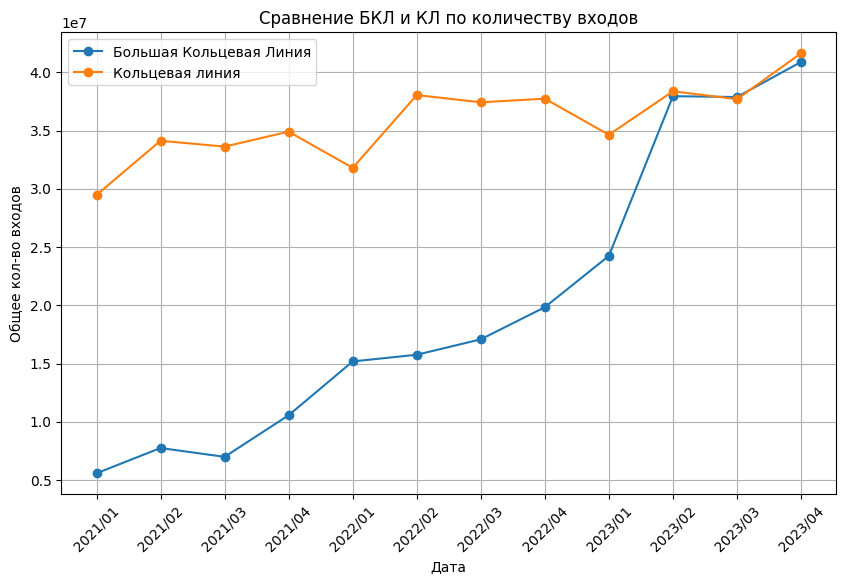

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(bolshaya_koltsevaya_grouped.index, bolshaya_koltsevaya_grouped.values, marker='o', linestyle='-', label='Большая Кольцевая Линия')
plt.plot(koltsevaya_grouped.index, koltsevaya_grouped.values, marker='o', linestyle='-', label='Кольцевая линия')
plt.xlabel('Дата')
plt.ylabel('Общее кол-во входов')
plt.title('Сравнение БКЛ и КЛ по количеству входов')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Действительно, количество людей на БКЛ растет и догоняет КЛ, то есть к 2024 можно констатировать, что БКЛ стала полноценным кольцом МосМетро

Таким образом, мы фактически частично подтвердили сильную гипотезу, что количество людей, пользующихся общественном транспортом растет по мере его улучшения, иначе говоря, разгрузка не распределяется.
Но может быть, вторая гипотеза не опровергает первую? Что если на КЛ количество людей действительно упало в процентном соотношении к общему количеству пассажиров, то есть что если КЛ действительно разгрузилась относительно остальных линий метро? Особенно интересует, разгрузилась ли КЛ в сторону БКЛ?

Для этого, давайте найдем важный показатель для каждой линии и каждой даты. В каждую дату будем суммировать количество людей, вошедших на каждой станции линии и делить на количество людей вошедших в метро всего. В комментариях будем называть это TIDLTID, то есть общее количество входящих людей на линии к общему количеству людей вошедших в метро. 

Проведем эти подсчеты для каждой линии и будем сравнивать с фиксированным показателем для БКЛ. То есть мы будем считать TIDLTID для каждой линии и сравнивать с TIDLTID для БКЛ в динамике. Кроме того, давайте выводить показатель корреляции между этими показателями для каждой линии.

In [87]:
total_incoming_per_date_line = df.groupby(['Date', 'Line'])['IncomingPassengers'].sum()

total_incoming_per_date_line_unstacked = total_incoming_per_date_line.unstack()

# Находим TID
total_incoming_per_date = total_incoming_per_date_line_unstacked.sum(axis=1)

# Эта функция будет считать TIDLTID и выводить график с ним для выбранной линии
def plot_percentages(selected_line):
    # считаем TIDLTID для линии
    percentage_selected_line = total_incoming_per_date_line_unstacked[selected_line] / total_incoming_per_date * 100
    # считаем TIDLTID для БКЛ
    percentage_bolshaya_koltsevaya_all = total_incoming_per_date_line_unstacked['Большая кольцевая линия'] / total_incoming_per_date * 100
    
    # Нарисуем
    plt.figure(figsize=(10, 6))
    plt.plot(percentage_selected_line.index[:-1], percentage_selected_line.values[:-1], marker='o', linestyle='-', label=f'TIDLTID {selected_line}')
    plt.plot(percentage_bolshaya_koltsevaya_all.index[:-1], percentage_bolshaya_koltsevaya_all.values[:-1], marker='o', linestyle='-', label='TIDLTID БКЛ')
    plt.xlabel('Дата')
    plt.ylabel('TIDLTID')
    plt.title(f'TIDLTID {selected_line} и TIDLTID БКЛ')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Найдем коэф. корреляции
    correlation_coefficient = np.corrcoef(percentage_selected_line[:-1], percentage_bolshaya_koltsevaya_all[:-1])[0, 1]
    print(f'Коэффициент корреляции {selected_line} и БКЛ: {correlation_coefficient:.2f}')

# Создаем виджет с выбором линий
line_selection = widgets.Dropdown(
    options=lines,
    value='Кольцевая',  
    description='Lines:'
)

# Выводим виджет с функцией
widgets.interact(plot_percentages, selected_line=line_selection)

interactive(children=(Dropdown(description='Lines:', index=6, options=('Большая кольцевая линия', 'МЦК', 'Соко…

<function __main__.plot_percentages(selected_line)>

Можно повыводить разные графики и поискать разные коэфкоры. Тут стоит отметить, что кольцевая по этому показателю все равно имеет положительный коэфкор с БКЛ, в то время как МЦК (в некотором смысле дублер БКЛ, но менее удобный) имеет сильный отрицательный коэфкор. С остальными линиями, то есть радиальными, ситуация иная. Некоторые линии, такие как Солнцевская, Некрасовская и Сокольническая имеют положительный коэфкор, в то время как другие, например Арбатская и Замоскворецкая имеют отрицательный коэфкор. 

Таким образом, мы отвергаем часть первой слабой гипотезы, что кольцевая линия разгрузилась после открытия БКЛ. И в абсолютных и в относительных значениях мы видим, что нагрузка на Кольцевой линии положительно связана с растущей нагрузкой на БКЛ. Это в очередной раз подтверждает сильную гипотезу, в этот раз неявным образом. В этом случае мы говорим о том, что больше людей стали пользоваться КЛ после открытия БКЛ. КЛ выступает главной пересадочной линией, то есть больше людей стали пользоваться главным пересадочным маршрутом, что явно говорит нам о том, что открытие БКЛ привело к расширению пользования метро. Логика простая - чем больше людей пользуются пересадкой, тем большему (с учетом того, что массовых закрытий станций не было), количеству людей нужна эта пересадка. Раз станции не закрывались, значит, что метро не стало менее доступным, а значит единственное возможное объяснение (при +- постоянном населении города) - изменение спроса на общественный транспорт. В таком случае, мы констатируем, что повышение предложения публичного транспорта привело к повышению спроса на публичный транспорт в большей мере, чем изменилось предложение

Давайте теперь разберемся с радиальными линиями, то есть посмотрим выросло ли относительное использование каждой станции радиальных линий (SIDLTID). 

Будем рассматривать нагрузку на каждую станцию в дату 2021/01, а затем для каждой выбранной даты и каждой выбранной линии на карте посмотрим на изменение. Если относительное использование станции выросло по сравнению с первоначальным SIDLTID, то будем обозначать красным кружком, если упало - зеленым, если станция закрыта (на ней 0 пассажиров) - синим. Радиус кружочка будет пропорционален размеру дельты между нынешнем SIDLTID и SIDLTID на период 2021/01

In [91]:
# На всякий случае пересчитаем суммарно всех пассажиров в изначальную дату
total_passengers_initial_date = df[df['Date'] == '2021/01']['IncomingPassengers'].sum()

# Здесь будем искать разницу между показателями сейчас и раньше в процентах
def calculate_station_percentages(line_selection):
    # Берем инфу на 2021/01
    initial_date_data = df[df['Date'] == '2021/01']
    # Фильтруем конкретную дату
    selected_line_data = initial_date_data[initial_date_data['Line'] == line_selection]
    total_passengers_per_station = selected_line_data.groupby('NameOfStation')['IncomingPassengers'].sum()
    
    # Находим изначальный процент
    percentages = (total_passengers_per_station / total_passengers_initial_date) * 100

    return percentages

# Уже знакомая функция для карты
def update_map(selected_line, selected_date):
    print(f"Карта для: {selected_line}, дата: {selected_date}")

    m = folium.Map(location=[55.7525, 37.6231], zoom_start=10)

    # Фильтруем по дате и линии
    selected_line_data = df[(df['Line'] == selected_line) & (df['Date'] == selected_date)]
    
    # ифаем исключения
    if selected_line_data.empty:
        print(f" По ({selected_line}) нет информации на ({selected_date}).")
        return
    
    # находим инфу в процентах для нужной линии
    percentages = calculate_station_percentages(selected_line)
    #находим общее количество пассажиров в выбранную дату
    total_passengers_current_date = df[df['Date'] == selected_date]['IncomingPassengers'].sum()
    
    # Ставим кружочки
    for index, row in selected_line_data.iterrows():
        # Здесь просто находим локацию станции
        station_name = row['NameOfStation']
        station_geo_info = df_geo[df_geo['station'] == station_name]
        if station_geo_info.empty:
            print(f"No geo information for station: {station_name}")
            continue
        station_lat = station_geo_info.iloc[0]['lat']
        station_lng = station_geo_info.iloc[0]['lng']
        incoming_passengers = row['IncomingPassengers']
        # Находим изначальный процент
        initial_percentage = percentages.get(station_name, 0)
        # Находим нынешний процент
        current_percentage = (incoming_passengers / total_passengers_current_date) * 100
        
        # Ифаем случай закрытой станции
        if incoming_passengers == 0:
            # Создаем синий кружок, если станция закрыта
            folium.CircleMarker(
                location=[station_lat, station_lng],
                radius=3,
                color='blue',
                fill=True,
                fill_opacity=0.5,
                popup=f'<b>{station_name}</b><br>Станция на реконструкции'
            ).add_to(m)
        else:
            # Иначе находим размер кружочка как модуль изменения процента
            size_factor = abs(current_percentage - initial_percentage)
            radius = 50*size_factor
            
            # Выбираем цвет кружочка 
            if current_percentage > initial_percentage:
                color = 'red'
            else:
                color = 'green'
            
            # Создаем маркер с определенным размерами и цветом
            folium.CircleMarker(
                location=[station_lat, station_lng],
                radius=radius,
                color=color,
                fill=True,
                fill_opacity=0.5,
                popup=f'<b>{station_name}</b><br>Входов: {incoming_passengers}<br>Процентное изменение: {current_percentage:.2f}%'
            ).add_to(m)
    
    #Выводим карту
    display(m)

# Виджеты
line_selection_widget = widgets.Dropdown(options=df['Line'].unique(), description='Select Line:', disabled=False)
date_selection_widget = widgets.Dropdown(options=df['Date'].unique(), description='Select Date:', disabled=False)

# функция, которая позволит нам выбирать и линию, и дату
def on_selection_change(selected_line, selected_date):
    update_map(selected_line, selected_date)

# Привязываем
widgets.interact(on_selection_change, selected_line=line_selection_widget, selected_date=date_selection_widget)

# Выводим виджеты
display(line_selection_widget)
display(date_selection_widget)


interactive(children=(Dropdown(description='Select Line:', options=('Большая кольцевая линия', 'МЦК', 'Сокольн…

Dropdown(description='Select Line:', options=('Большая кольцевая линия', 'МЦК', 'Сокольническая', 'Замоскворец…

Dropdown(description='Select Date:', options=('2024/04', '2024/01', '2023/04', '2023/03', '2023/02', '2023/01'…

Мы увидели довольно интересную картину, многие станции действительно разгрузились, многие станции, наоборот, нагрузились сильнее. Часто это может быть связано не с открытием БКЛ, а, например, с социальными факторами или изменением городской инфраструктуры. Стоит заметить, что чаще всего пересадочные на БКЛ станции разгрузились, таким образом здесь мы видим факт, который мы получили еще довольно давно, но теперь он статистически сильный. <br>
Осталось самое главное: нам нужно понять, перекрывают ли зеленые кружочки красные кружочки. Иными словами, перекрывает ли разгрузка на некоторых станциях загрузку на других? С кольцевой линией мы уже оценили и пришли к тому, что на кольцевой гипотеза о разгрузке опроверглась. Теперь осталось проверить самую сложную часть слабой гипотезы - разгрузку радиальных веток. <br>
На карте мы видим, что это вполне реалистично, ведь зеленые кружочки на многих ветках больше, чем красные. Но в любом случае, давайте лучше посчитаем

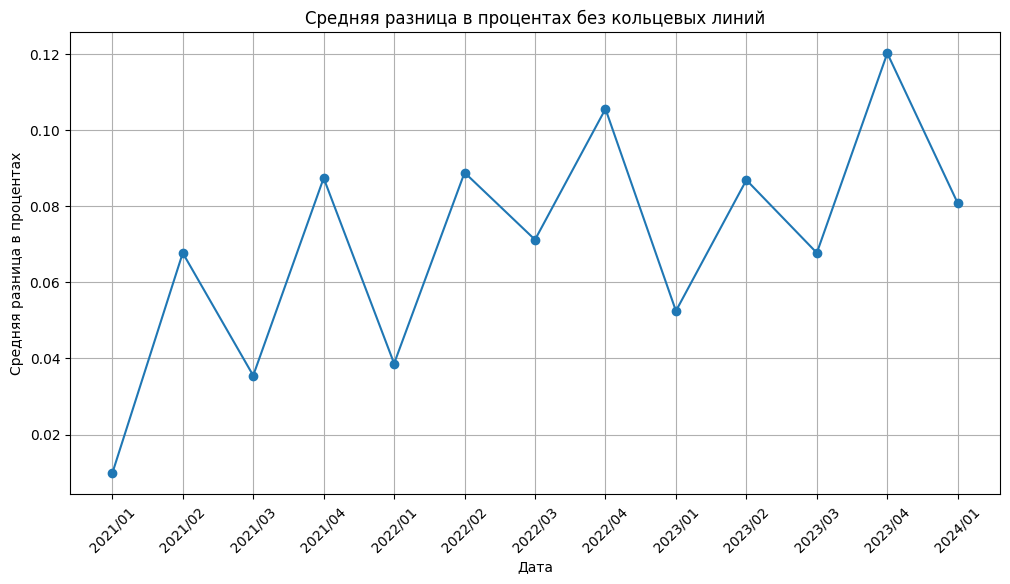

interactive(children=(Dropdown(description='Date', options=('2021/01', '2021/02', '2021/03', '2021/04', '2022/…

<function __main__.display_average_percentage_difference(selected_date)>

In [93]:
#Удаляем кольцевые линии из статистики
excluded_lines = ['Кольцевая', 'МЦК', 'Большая кольцевая линия']
filtered_df = df[~df['Line'].isin(excluded_lines)]

# Находим уже знакомый TID на 2021/01
total_passengers_initial_date = filtered_df[filtered_df['Date'] == '2021/01']['IncomingPassengers'].sum()

# Функция для подсчета изначальных значений дял каждой линии
def calculate_initial_percentages():
    initial_date_data = filtered_df[filtered_df['Date'] == '2021/01']
    percentages = {}
    #по каждой лини для каждой станции находим изначальный SIDLTID
    for line in filtered_df['Line'].unique():
        line_data = initial_date_data[initial_date_data['Line'] == line]
        for station, passengers in line_data.groupby('NameOfStation')['IncomingPassengers'].sum().items():
            percentages[station] = passengers / total_passengers_initial_date * 100

    return percentages

# Получаем изначальные проценты для всех станций
initial_percentages = calculate_initial_percentages()

# Теперь будем считать различие с каждой датой
def calculate_average_percentage_difference(selected_date):
    selected_date_data = filtered_df[filtered_df['Date'] == selected_date]
    differences = []
    for line in filtered_df['Line'].unique():
        line_data = selected_date_data[selected_date_data['Line'] == line]
        # проходимся и находим разницу для каждой станции
        for station, passengers in line_data.groupby('NameOfStation')['IncomingPassengers'].sum().items():
            initial_percentage = initial_percentages.get(station, 0)
            current_percentage = passengers / total_passengers_initial_date * 100
            difference = current_percentage - initial_percentage
            differences.append(difference)
    # на выход получаем процент 
    return sum(differences) / len(differences) if differences else 0

# Находим среднее для каждой даты
dates = sorted(filtered_df['Date'].unique())
average_differences = [calculate_average_percentage_difference(date) for date in dates]

# График
plt.figure(figsize=(12, 6))
plt.plot(dates, average_differences, marker='o', linestyle='-')
plt.xlabel('Дата')
plt.ylabel('Средняя разница в процентах')
plt.title('Средняя разница в процентах без кольцевых линий')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Виджет для получения конкретного значения с графика
date_selection_widget = widgets.Dropdown(options=dates, description='Date')

# Функция для вывода информации о конкретной точки по выбранной дате
def display_average_percentage_difference(selected_date):
    avg_diff = calculate_average_percentage_difference(selected_date)
    if avg_diff > 0:
        print(f"Средняя разница в процентах {selected_date}: {avg_diff:.2f}% (Положительная)")
    elif avg_diff < 0:
        print(f"Средняя разница в процентах {selected_date}: {avg_diff:.2f}% (Отрицательная)")
    else:
        print(f"Средняя разница в процентах {selected_date}: {avg_diff:.2f}% (Нет изменений)")

# Виджет
widgets.interact(display_average_percentage_difference, selected_date=date_selection_widget)


Примечательно! В среднем нагрузка на станции выросла. Действительно, могло такое произойти, что некоторые линии разгрузились до 12%, но в среднем радиальные линии имеют не разгрузку, а наоборот, нагрузку. Таким образом, вторая часть слабой гипотезы тоже отвергается - разгрузки радиальных направлений в среднем не произошло. Более того, такая информация очередной раз подтверждает сильную гипотезу.

<b>Выводы</b>

Полученные статистические выкладки позволяют заявить, что слабая гипотеза - "после открытия БКЛ остальные линии разгрузились; Первая часть слабой гипотезы - кольцевая линия разгрузилась на 23%, вторая часть - радиальные линии разгрузились до 12%" может быть отвергнута хотя бы частично. Первая часть гипотезы не выдерживает статистической проверки, вторая часть при желании спекулировать фактами может быть принята, так как -n% это до 12%, но я считаю, что честнее дать ей статус "отвергнута почти наверняка". 

Сильная гипотеза - "Открытие новых маршрутов общественного транспорта, в частности, метро, приводит к тому, что рост проса превышает рост предложения, создавая превышающую первоначальные значения нагрузку" может быть принята на основе данных, так как действительно, нагрузка на все метро в целом и на разные линии в частности скорее выросла по сравнению с 2021/01. 

Само собой, для тестирования сильной гипотезы необходимо большее количество данных о разных исторических периодах, разных городах, разных странах и разных путей развития метрополитена, однако работа не ставила целью углубление в урбанистику. Кроме того, важно отметить, что даже за выбранный исторический период в данных произошло значительное количество социальных, политических и иных шоков, которые явно могли повлиять на статистику. Нормирование на них не представляется возможным в связи с уникальностью проекта БКЛ не только в Московской, но и в мировой практике. 